# 🏷️ Step 5 : Mini-Taxonomy of Definitions

**Objectif**: Extraire et classifier les définitions d'"Agentic AI" dans le corpus

**Approche hybride**:
1. **Extraction semi-automatique** - Identifier les paragraphes définitionnels
2. **Classification manuelle** - Grouper en catégories conceptuelles
3. **Visualisation** - Tableaux et diagrammes (treemap, sunburst)

**Catégories attendues**:
- AI as Copilots/Assistants
- AI as Autonomous Workers
- AI as Multi-Agent Ecosystems/Orchestrators
- AI as Governance/Risk Challenges

**Output**: Taxonomie des définitions + visualisations pour le rapport

## 🔧 Setup Config & Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Imports
import json
import re
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.tokenize import sent_tokenize

# Viz
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✅ Imports")

✅ Imports


## 📂 Load processed corpus

In [2]:
# Paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"
TEXTS_DIR = PROCESSED_DATA / "texts"
METADATA_FILE = PROCESSED_DATA / "metadata" / "corpus_metadata.json"

# Create taxonomy folder
TAXONOMY_DIR = PROCESSED_DATA / "taxonomy"
TAXONOMY_DIR.mkdir(exist_ok=True)

print(f"📁 Taxonomy folder : {TAXONOMY_DIR}")

📁 Taxonomy folder : c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy


In [3]:
# Load raw texts
texts = {}
with open(METADATA_FILE, 'r', encoding='utf-8') as f:
    metadata = json.load(f)

for doc_id in metadata.keys():
    text_file = TEXTS_DIR / f"{doc_id}.txt"
    if text_file.exists():
        with open(text_file, 'r', encoding='utf-8') as f:
            texts[doc_id] = f.read()

print(f"✅ {len(texts)} documents loaded")

✅ 20 documents loaded


In [4]:
# Mapping doc_id -> source_type
doc_to_source = {doc_id: metadata[doc_id]['source_type'] 
                 for doc_id in texts.keys()}

## 🔍 Semi-automatic extraction of definition

### Extraction strategy

Nous allons identifier les phrases/paragraphes qui:
1. Contiennent des termes clés: "agentic ai", "ai agent", "autonomous agent"
2. Utilisent des marqueurs définitionnels: "is", "are", "defined as", "refers to", "means"
3. Sont dans les premières sections (introduction, definitions)

In [5]:
def extract_definition_candidates(text, doc_id):
    """
    Extract candidate phrases as definitions.
    
    Criterias:
    - Contains key terms (agentic, agent, autonomous)
    - Contains definitional markers
    - Reasonable length (30-300 words)
    """
    # Tokenize in phrases
    sentences = sent_tokenize(text)
    
    # Key terms to search
    key_terms = [
        r'\bagentic\s+ai\b',
        r'\bai\s+agent[s]?\b',
        r'\bautonomous\s+agent[s]?\b',
        r'\bagentic\s+system[s]?\b',
        r'\bagent[s]?\s+are\b',
        r'\bagent[s]?\s+is\b'
    ]
    
    # Definitional markers
    def_markers = [
        r'\bis\s+defined\s+as\b',
        r'\bare\s+defined\s+as\b',
        r'\brefers?\s+to\b',
        r'\bmeans?\b',
        r'\bcan\s+be\s+understood\s+as\b',
        r'\bcharacterized\s+by\b',
        r'\bconsists?\s+of\b',
        r'\benables?\b',
        r'\bcapable\s+of\b'
    ]
    
    candidates = []
    
    for i, sentence in enumerate(sentences):
        sentence_lower = sentence.lower()
        
        # Check key terms presence
        has_key_term = any(re.search(pattern, sentence_lower) for pattern in key_terms)
        
        if not has_key_term:
            continue
        
        # Check definitional markers presence
        has_def_marker = any(re.search(pattern, sentence_lower) for pattern in def_markers)
        
        # Check length
        word_count = len(sentence.split())
        
        # Score phrase
        score = 0
        if has_key_term:
            score += 2
        if has_def_marker:
            score += 3
        if 30 <= word_count <= 300:
            score += 1
        if i < len(sentences) * 0.3:  # In first 30%
            score += 1
        
        if score >= 3:
            # Extract next phrase for context
            context = sentence
            if i + 1 < len(sentences):
                context += " " + sentences[i + 1]
            
            candidates.append({
                'doc_id': doc_id,
                'sentence_id': i,
                'text': sentence.strip(),
                'context': context.strip(),
                'word_count': word_count,
                'score': score,
                'has_def_marker': has_def_marker
            })
    
    return candidates

In [6]:
# Extract candidates for docs
all_candidates = []

for doc_id, text in texts.items():
    candidates = extract_definition_candidates(text, doc_id)
    all_candidates.extend(candidates)
    
    filename = metadata[doc_id]['filename']
    print(f"\n📄 {filename}")
    print(f"   {len(candidates)} potential definitions found")

print(f"\n✅ Total: {len(all_candidates)} candidate definitions extracted")


📄 Bain_report_technology_report_2025.pdf
   18 potential definitions found

📄 BCG_AI_Agents_2025.pdf
   27 potential definitions found

📄 Deloitte_The_business_imperative_for_Agentic_AI_2025.pdf
   48 potential definitions found

📄 Google_Agentic_AI_TAM_Analysis_2025.pdf
   126 potential definitions found

📄 Google_The_ROI_of_AI_2025.pdf
   10 potential definitions found

📄 Harvard_Designing_a_Successful_Agentic_AI_System_2025.pdf
   31 potential definitions found

📄 ITI_Understanding_Agentic_AI_Policy_Guide_2025.pdf
   86 potential definitions found

📄 McKinsey_Empowering_advanced_industries_with_agentic_AI_2025.pdf
   25 potential definitions found

📄 McKinsey_The_agentic_organization_contours_of_the_next_paradigm_for_the_AI_era_2025.pdf
   14 potential definitions found

📄 McKinsey_What_is_an_AI_Agent_2025.pdf
   33 potential definitions found

📄 Microsoft_Agent_AI_Towards_a_Holistic_Intelligence_2025.pdf
   5 potential definitions found

📄 MIT_Reimagining_the_future_of_banking_wit

### Extracted definitions overview

In [7]:
# Create DataFrame
df_candidates = pd.DataFrame(all_candidates)

# Add metadata
df_candidates['filename'] = df_candidates['doc_id'].map(
    lambda x: metadata[x]['filename']
)
df_candidates['source_type'] = df_candidates['doc_id'].map(doc_to_source)

# Desc score order
df_candidates = df_candidates.sort_values('score', ascending=False)

print("TOP 10 CANDIDATE DEFINITIONS (by score)")
for i, row in df_candidates.head(10).iterrows():
    print(f"\n{row['filename']} (Score: {row['score']})")
    print(f"  {row['text'][:200]}...")

TOP 10 CANDIDATE DEFINITIONS (by score)

Google_Agentic_AI_TAM_Analysis_2025.pdf (Score: 7)
  issues approvals and propensity to buy teams, publishes eligible patients refines according to performance Note: Based on interviews with partners and Google industry solution leaders; Source: Partner...

McKinsey_Empowering_advanced_industries_with_agentic_AI_2025.pdf (Score: 7)
  Capable of perceiving context, reasoning through complex and multistep challenges, and acting independently across digital systems, AI agents represent the next wave of artificial intelligence, with t...

PwC_Agentic_AI_the_new_frontier_in_GenAI_2024.pdf (Score: 7)
  Integration of ML (2000s) NLP enabled user Learning from data interactions Integration of Machine Learning (2000s) Introduction of multimodality (2010s) Natural Language Processing LCeoamrnbiningi nfr...

WEF_AI_Agents_in_Action_Foundations_for_Evaluation_and_Governance_2025.pdf (Score: 7)
  This section organizations begin to “hire” AI agents to suppor

## 📝 Manual classification of definitions

**IMPORTANT**: Cette section nécessite une révision manuelle.

Pour chaque définition candidate, tu dois:
1. Lire le texte complet
2. Assigner une catégorie
3. Éventuellement fusionner ou supprimer certaines entrées

In [8]:
# Define taxonomy categories
TAXONOMY_CATEGORIES = {
    'copilot': {
        'label': 'AI as Copilots/Assistants',
        'description': 'AI agents that augment human work, provide suggestions, collaborate with users',
        'keywords': ['copilot', 'assistant', 'augment', 'support', 'collaborate', 'suggest', 'help']
    },
    'autonomous_worker': {
        'label': 'AI as Autonomous Workers',
        'description': 'AI agents that independently execute tasks with minimal human intervention',
        'keywords': ['autonomous', 'independent', 'execute', 'automate', 'replace', 'perform']
    },
    'orchestrator': {
        'label': 'AI as Multi-Agent Ecosystems/Orchestrators',
        'description': 'AI systems coordinating multiple agents, workflows, or complex processes',
        'keywords': ['orchestrate', 'coordinate', 'multi-agent', 'ecosystem', 'workflow', 'multi-step', 'planning']
    },
    'governance': {
        'label': 'AI as Governance/Risk Challenges',
        'description': 'AI agents framed through ethical, regulatory, or risk management lens',
        'keywords': ['governance', 'risk', 'compliance', 'regulation', 'ethics', 'safety', 'alignment', 'control']
    },
    'other': {
        'label': 'Other/Uncategorized',
        'description': 'Definitions that don\'t fit main categories',
        'keywords': []
    }
}

print("\n📋 Taxonomy categories:")
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    print(f"\n  {cat_info['label']}")
    print(f"    {cat_info['description']}")
    print(f"    Key words: {', '.join(cat_info['keywords'][:5])}")


📋 Taxonomy categories:

  AI as Copilots/Assistants
    AI agents that augment human work, provide suggestions, collaborate with users
    Key words: copilot, assistant, augment, support, collaborate

  AI as Autonomous Workers
    AI agents that independently execute tasks with minimal human intervention
    Key words: autonomous, independent, execute, automate, replace

  AI as Multi-Agent Ecosystems/Orchestrators
    AI systems coordinating multiple agents, workflows, or complex processes
    Key words: orchestrate, coordinate, multi-agent, ecosystem, workflow

  AI as Governance/Risk Challenges
    AI agents framed through ethical, regulatory, or risk management lens
    Key words: governance, risk, compliance, regulation, ethics

  Other/Uncategorized
    Definitions that don't fit main categories
    Key words: 


### Semi-automatic classification (First try)

On utilise les mots-clés pour suggérer une catégorie, mais la validation manuelle sera nécessaire.

In [9]:
def suggest_category(text):
    """
    Suggest a category based on key-words.
    """
    text_lower = text.lower()
    
    scores = {}
    for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
        if cat_id == 'other':
            continue
        
        score = sum(1 for keyword in cat_info['keywords'] if keyword in text_lower)
        scores[cat_id] = score
    
    if max(scores.values()) == 0:
        return 'other', 0
    
    suggested_cat = max(scores.items(), key=lambda x: x[1])[0]
    confidence = scores[suggested_cat]
    
    return suggested_cat, confidence

In [10]:
# Suggest cats
df_candidates['suggested_category'] = df_candidates.apply(
    lambda row: suggest_category(row['text'])[0], axis=1
)
df_candidates['category_confidence'] = df_candidates.apply(
    lambda row: suggest_category(row['text'])[1], axis=1
)

In [11]:
print("SUGGESTION FOR CLASSIFICATION")
for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance', 'other']:
    count = (df_candidates['suggested_category'] == cat_id).sum()
    print(f"  {TAXONOMY_CATEGORIES[cat_id]['label']:45} : {count:2} definitions")

SUGGESTION FOR CLASSIFICATION
  AI as Copilots/Assistants                     : 79 definitions
  AI as Autonomous Workers                      : 92 definitions
  AI as Multi-Agent Ecosystems/Orchestrators    : 65 definitions
  AI as Governance/Risk Challenges              : 97 definitions
  Other/Uncategorized                           : 417 definitions


### Export for manual classification

In [12]:
# Create CSV file for manual checking
review_df = df_candidates[[
    'filename', 'source_type', 'text', 'context', 
    'suggested_category', 'category_confidence'
]].copy()

# Add empty column for final category (to be filled manually)
review_df['final_category'] = review_df['suggested_category']
review_df['notes'] = ''
review_df['keep'] = True  # To mark definitions to keep

# Save
review_file = TAXONOMY_DIR / 'definitions_for_manual_review.csv'
review_df.to_csv(review_file, index=False, encoding='utf-8')

print(f"\n💾 File for manual review: {review_file}")
print("\n⚠️  MANUAL REVIEW REQUIRED:")
print("   1. Open the CSV file in Excel/Google Sheets")
print("   2. Read each definition")
print("   3. Correct the 'final_category' column if necessary")
print("   4. Set 'keep' to False for irrelevant definitions")
print("   5. Add notes if needed")
print("   6. Save the file")


💾 File for manual review: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\definitions_for_manual_review.csv

⚠️  MANUAL REVIEW REQUIRED:
   1. Open the CSV file in Excel/Google Sheets
   2. Read each definition
   3. Correct the 'final_category' column if necessary
   4. Set 'keep' to False for irrelevant definitions
   5. Add notes if needed
   6. Save the file


## 📊 Manually reviewed candidate definitions loading

In [13]:
# **NOTE**: Après avoir complété la révision manuelle du CSV, exécutez cette section.

# Check if reviewed file exists
reviewed_file = TAXONOMY_DIR / 'definitions_for_manual_review.csv'

if reviewed_file.exists():
    df_reviewed = pd.read_csv(reviewed_file)
    df_definitions = df_reviewed[df_reviewed['keep'] == True].copy()
    
    print(f"✅ Manual results loaded: {len(df_definitions)} definitions validated")
    
    category_col = 'final_category'
else:
    print("⚠️  Reviewed file not found. Using automatic classification.")
    df_definitions = df_candidates.copy()
    df_definitions['final_category'] = df_definitions['suggested_category']
    category_col = 'final_category'

# Clean invalid categories
valid_categories = list(TAXONOMY_CATEGORIES.keys())
df_definitions[category_col] = df_definitions[category_col].apply(
    lambda x: x if x in valid_categories else 'other'
)

✅ Manual results loaded: 750 definitions validated


In [14]:
print(f"\n📊 Definition final distribution:")
for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance', 'other']:
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    print(f"  {TAXONOMY_CATEGORIES[cat_id]['label']:45} : {count:2} ({pct:5.1f}%)")


📊 Definition final distribution:
  AI as Copilots/Assistants                     : 79 ( 10.5%)
  AI as Autonomous Workers                      : 92 ( 12.3%)
  AI as Multi-Agent Ecosystems/Orchestrators    : 65 (  8.7%)
  AI as Governance/Risk Challenges              : 97 ( 12.9%)
  Other/Uncategorized                           : 417 ( 55.6%)


## 📋 Definitions Table

In [17]:
table_data = []

for _, row in df_definitions.iterrows():
    table_data.append({
        'Report': row['filename'][:40],
        'Source Type': row['source_type'],
        'Category': TAXONOMY_CATEGORIES[row[category_col]]['label'],
        'Definition': row['text'][:150] + '...' if len(row['text']) > 150 else row['text']
    })

df_table = pd.DataFrame(table_data)
df_table.head()

,Report,Source Type,Category,Definition
0,Google_Agentic_AI_TAM_Analysis_2025.pdf,Industry,AI as Autonomous Workers,"issues approvals and propensity to buy teams, ..."
1,McKinsey_Empowering_advanced_industries_,Consulting,AI as Autonomous Workers,"Capable of perceiving context, reasoning throu..."
2,PwC_Agentic_AI_the_new_frontier_in_GenAI,Consulting,AI as Governance/Risk Challenges,Integration of ML (2000s) NLP enabled user Lea...
3,WEF_AI_Agents_in_Action_Foundations_for_,Policy,AI as Copilots/Assistants,This section organizations begin to “hire” AI ...
4,WEF_AI_Agents_in_Action_Foundations_for_,Policy,AI as Autonomous Workers,towards agentic AI represents a fundamental ch...


In [18]:
df_table.to_csv(TAXONOMY_DIR / 'definitions_table.csv', index=False, encoding='utf-8')
print(f"💾 Table saved to: {TAXONOMY_DIR / 'definitions_table.csv'}")

💾 Table saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\definitions_table.csv


In [19]:
print("\n📋 Examples per categories:\n")

for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance']:
    cat_label = TAXONOMY_CATEGORIES[cat_id]['label']
    cat_defs = df_table[df_table['Category'] == cat_label]
    
    if len(cat_defs) == 0:
        continue
    
    print(f"{'─'*70}")
    print(f"{cat_label}")
    print(f"{'─'*70}")
    
    for _, row in cat_defs.head(2).iterrows():
        print(f"\n  📄 {row['Report']}")
        print(f"     {row['Definition']}")
    
    print()


📋 Examples per categories:

──────────────────────────────────────────────────────────────────────
AI as Copilots/Assistants
──────────────────────────────────────────────────────────────────────

  📄 WEF_AI_Agents_in_Action_Foundations_for_
     This section organizations begin to “hire” AI agents to support or outlines the technical foundations that enable agentic augment human teams, or perf...

  📄 WEF_AI_Agents_in_Action_Foundations_for_
     At a high level, agent architectures are designed to interface To enable this shift, AI agents draw on four with users and systems, coordinate complex...

──────────────────────────────────────────────────────────────────────
AI as Autonomous Workers
──────────────────────────────────────────────────────────────────────

  📄 Google_Agentic_AI_TAM_Analysis_2025.pdf
     issues approvals and propensity to buy teams, publishes eligible patients refines according to performance Note: Based on interviews with partners and...

  📄 McKinsey_Empower

## 📊 Taxonomy visualization

### Global distribution

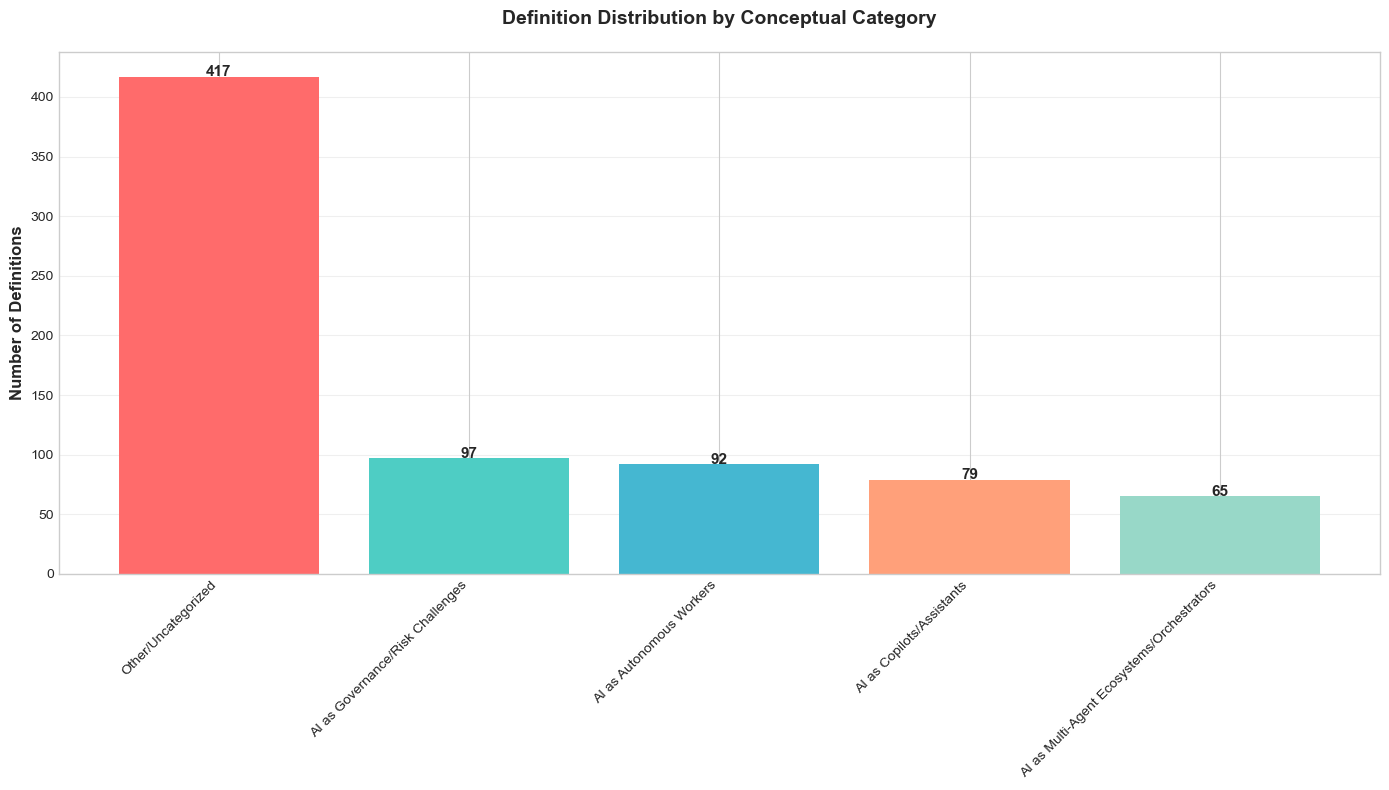

💾 Graph saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_distribution.png


In [21]:
# Count definitions per category
category_counts = df_definitions[category_col].value_counts()

# Create mapping to full labels
category_labels = {cat_id: TAXONOMY_CATEGORIES[cat_id]['label'] 
                  for cat_id in category_counts.index}
category_counts.index = category_counts.index.map(category_labels)

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
bars = ax.bar(range(len(category_counts)), category_counts.values, 
             color=colors[:len(category_counts)], linewidth=1.5)

ax.set_xticks(range(len(category_counts)))
ax.set_xticklabels(category_counts.index, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('Number of Definitions', fontsize=12, fontweight='bold')
ax.set_title('Definition Distribution by Conceptual Category', 
            fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, category_counts.values)):
    ax.text(i, count + 0.5, str(count), ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(TAXONOMY_DIR / 'taxonomy_distribution.png', bbox_inches='tight')
plt.show()

print(f"💾 Graph saved to: {TAXONOMY_DIR / 'taxonomy_distribution.png'}")

### Distribution per source type

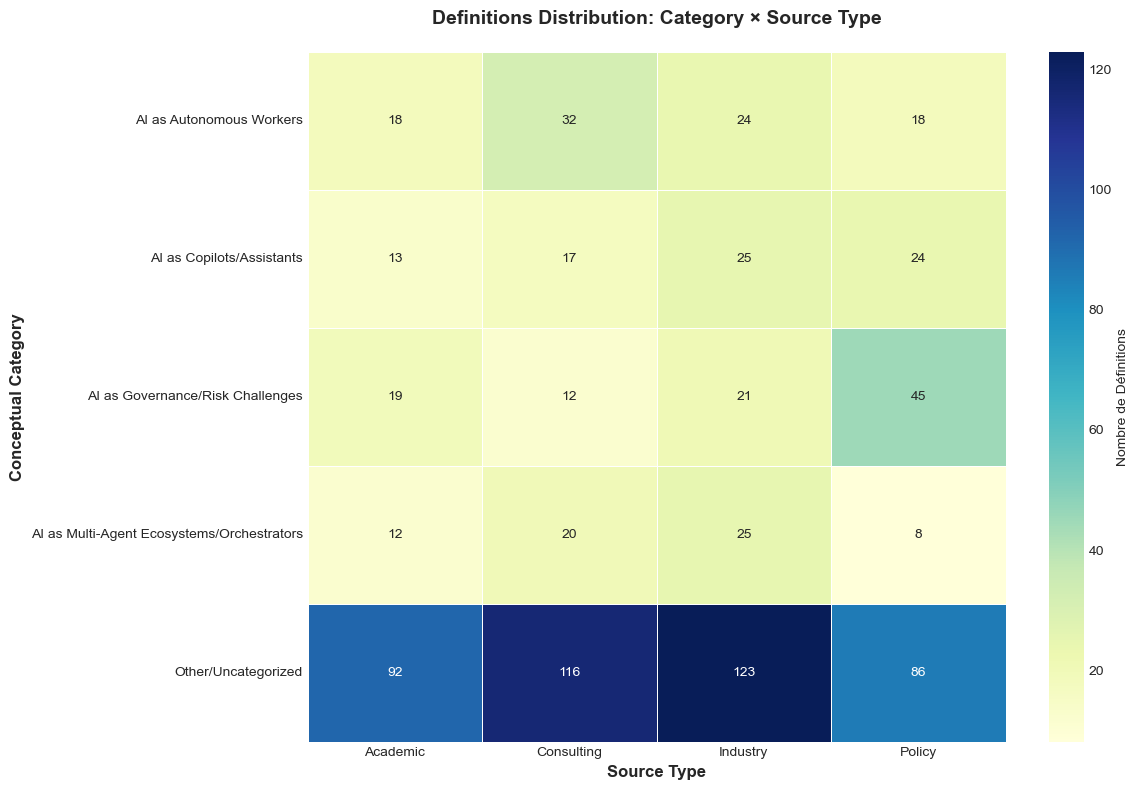

💾 Heatmap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_by_source_heatmap.png


In [22]:
# Create matrix category × source type
cross_tab = pd.crosstab(
    df_definitions[category_col].map(lambda x: TAXONOMY_CATEGORIES[x]['label']),
    df_definitions['source_type']
)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', 
           linewidths=0.5, cbar_kws={'label': 'Nombre de Définitions'}, ax=ax)

ax.set_xlabel('Source Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Conceptual Category', fontsize=12, fontweight='bold')
ax.set_title('Definitions Distribution: Category × Source Type', 
            fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(TAXONOMY_DIR / 'taxonomy_by_source_heatmap.png', bbox_inches='tight')
plt.show()

print(f"💾 Heatmap saved to: {TAXONOMY_DIR / 'taxonomy_by_source_heatmap.png'}")

### Treemap

In [23]:
treemap_data = []

for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    count = (df_definitions[category_col] == cat_id).sum()
    if count > 0:
        treemap_data.append({
            'category': cat_info['label'],
            'count': count,
            'parent': 'Agentic AI Definitions'
        })
        
        # Ajouter les sous-niveaux par type de source
        for source_type in df_definitions['source_type'].unique():
            source_count = ((df_definitions[category_col] == cat_id) & 
                          (df_definitions['source_type'] == source_type)).sum()
            if source_count > 0:
                treemap_data.append({
                    'category': f"{source_type} ({source_count})",
                    'count': source_count,
                    'parent': cat_info['label']
                })

df_treemap = pd.DataFrame(treemap_data)

In [24]:
# Add root node
root_count = df_definitions.shape[0]
df_treemap = pd.concat([
    pd.DataFrame([{'category': 'Agentic AI Definitions', 'count': root_count, 'parent': ''}]),
    df_treemap
], ignore_index=True)

# Treemap using Plotly
fig = px.treemap(
    df_treemap,
    names='category',
    parents='parent',
    values='count',
    title='hierarchical Taxonomy of Agentic AI Definitions',
    color='count',
    color_continuous_scale='RdYlBu_r'
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=18, family='Arial Black'),
    height=700
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_treemap.html')
fig.show()

print(f"💾 Treemap saved to: {TAXONOMY_DIR / 'taxonomy_treemap.html'}")

💾 Treemap saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_treemap.html


### Sunburst Chart

In [25]:
# Create sunburst chart
fig = px.sunburst(
    df_treemap,
    names='category',
    parents='parent',
    values='count',
    title='Definitions Taxonomy',
    color='count',
    color_continuous_scale='Viridis'
)

fig.update_layout(
    font=dict(size=13),
    title_font=dict(size=18, family='Arial Black'),
    height=700
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_sunburst.html')
fig.show()

print(f"💾 Sunburst saved to: {TAXONOMY_DIR / 'taxonomy_sunburst.html'}")

💾 Sunburst saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_sunburst.html


### Sankey Graph (Flow: Source Type → Category)

In [26]:
source_types = df_definitions['source_type'].unique()
categories = df_definitions[category_col].unique()

# Mappings
source_to_idx = {s: i for i, s in enumerate(source_types)}
cat_to_idx = {c: i + len(source_types) for i, c in enumerate(categories)}

In [27]:
# Flows
sources = []
targets = []
values = []
labels = list(source_types) + [TAXONOMY_CATEGORIES[c]['label'] for c in categories]

for _, row in df_definitions.iterrows():
    source_idx = source_to_idx[row['source_type']]
    target_idx = cat_to_idx[row[category_col]]
    
    # Check if existing flow
    try:
        idx = sources.index(source_idx)
        if targets[idx] == target_idx:
            values[idx] += 1
            continue
    except ValueError:
        pass
    
    sources.append(source_idx)
    targets.append(target_idx)
    values.append(1)

In [28]:
# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', 
               '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9'][:len(labels)]
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(
    title="Flux des Définitions: Type de Source → Catégorie Conceptuelle",
    font=dict(size=12),
    height=600
)

fig.write_html(TAXONOMY_DIR / 'taxonomy_sankey.html')
fig.show()

print(f"💾 Sankey sauvegardé: {TAXONOMY_DIR / 'taxonomy_sankey.html'}")

💾 Sankey sauvegardé: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_sankey.html


## 📊 Categories comparative analysis

In [29]:
# Stats per category
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    cat_defs = df_definitions[df_definitions[category_col] == cat_id]
    
    if len(cat_defs) == 0:
        continue
    
    print(f"{cat_info['label']}")
    
    print(f"  Total count      : {len(cat_defs)}")
    print(f"  Type distribution:")
    
    for source_type in cat_defs['source_type'].value_counts().index:
        count = (cat_defs['source_type'] == source_type).sum()
        pct = count / len(cat_defs) * 100
        print(f"    • {source_type:15} : {count:2} ({pct:5.1f}%)")

AI as Copilots/Assistants
  Total count      : 79
  Type distribution:
    • Industry        : 25 ( 31.6%)
    • Policy          : 24 ( 30.4%)
    • Consulting      : 17 ( 21.5%)
    • Academic        : 13 ( 16.5%)
AI as Autonomous Workers
  Total count      : 92
  Type distribution:
    • Consulting      : 32 ( 34.8%)
    • Industry        : 24 ( 26.1%)
    • Policy          : 18 ( 19.6%)
    • Academic        : 18 ( 19.6%)
AI as Multi-Agent Ecosystems/Orchestrators
  Total count      : 65
  Type distribution:
    • Industry        : 25 ( 38.5%)
    • Consulting      : 20 ( 30.8%)
    • Academic        : 12 ( 18.5%)
    • Policy          :  8 ( 12.3%)
AI as Governance/Risk Challenges
  Total count      : 97
  Type distribution:
    • Policy          : 45 ( 46.4%)
    • Industry        : 21 ( 21.6%)
    • Academic        : 19 ( 19.6%)
    • Consulting      : 12 ( 12.4%)
Other/Uncategorized
  Total count      : 417
  Type distribution:
    • Industry        : 123 ( 29.5%)
    • Consulti

## 📋 Summary for report

In [30]:
summary_text = f"""
MINI-TAXONOMY OF AGENTIC AI DEFINITIONS
{'='*70}

METHODOLOGY
{'-'*70}
• Semi-automatic extraction: {len(df_candidates)} candidate definitions
• Manual validation: {len(df_definitions)} definitions
• Categorization: 4 main conceptual categories

RESULTS
{'-'*70}
"""

for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    if cat_id == 'other':
        continue
    
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    
    summary_text += f"\n{cat_info['label']}: {count} definitions ({pct:.1f}%)\n"
    summary_text += f"  {cat_info['description']}\n"

summary_text += f"\n{'-'*70}\n"
summary_text += "KEY INSIGHTS\n"
summary_text += f"{'-'*70}\n"

# Identify dominant category
dominant_cat = df_definitions[category_col].value_counts().idxmax()
dominant_count = df_definitions[category_col].value_counts().max()
dominant_pct = dominant_count / len(df_definitions) * 100

summary_text += f"\n• Dominant category: {TAXONOMY_CATEGORIES[dominant_cat]['label']} ({dominant_pct:.1f}%)\n"

# Analyze per source type
summary_text += "\n• Differences per source type:\n"
for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    if len(source_defs) > 0:
        top_cat = source_defs[category_col].value_counts().idxmax()
        summary_text += f"  - {source_type}: favors '{TAXONOMY_CATEGORIES[top_cat]['label']}'\n"

print(summary_text)


MINI-TAXONOMY OF AGENTIC AI DEFINITIONS

METHODOLOGY
----------------------------------------------------------------------
• Semi-automatic extraction: 750 candidate definitions
• Manual validation: 750 definitions
• Categorization: 4 main conceptual categories

RESULTS
----------------------------------------------------------------------

AI as Copilots/Assistants: 79 definitions (10.5%)
  AI agents that augment human work, provide suggestions, collaborate with users

AI as Autonomous Workers: 92 definitions (12.3%)
  AI agents that independently execute tasks with minimal human intervention

AI as Multi-Agent Ecosystems/Orchestrators: 65 definitions (8.7%)
  AI systems coordinating multiple agents, workflows, or complex processes

AI as Governance/Risk Challenges: 97 definitions (12.9%)
  AI agents framed through ethical, regulatory, or risk management lens

----------------------------------------------------------------------
KEY INSIGHTS
----------------------------------------

In [31]:
summary_file = TAXONOMY_DIR / 'taxonomy_summary.txt'
with open(summary_file, 'w', encoding='utf-8') as f:
    f.write(summary_text)

print(f"\n💾 Summary saved to: {summary_file}")


💾 Summary saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_summary.txt


## 💾 Save results

In [32]:
# Defs with categories
df_definitions.to_csv(TAXONOMY_DIR / 'definitions_categorized.csv', 
                     index=False, encoding='utf-8')
print(f"✅ Categorized definitions saved to: {TAXONOMY_DIR / 'definitions_categorized.csv'}")

✅ Categorized definitions saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\definitions_categorized.csv


In [33]:
# Table
report_table = []
for cat_id, cat_info in TAXONOMY_CATEGORIES.items():
    if cat_id == 'other':
        continue
    
    cat_defs = df_definitions[df_definitions[category_col] == cat_id]
    
    for _, row in cat_defs.iterrows():
        report_table.append({
            'Category': cat_info['label'],
            'Report': row['filename'],
            'Source_Type': row['source_type'],
            'Definition_Excerpt': row['text'][:200] + '...' if len(row['text']) > 200 else row['text']
        })

df_report_table = pd.DataFrame(report_table)
df_report_table.to_csv(TAXONOMY_DIR / 'taxonomy_table_for_report.csv', 
                       index=False, encoding='utf-8')
print(f"✅ Table saved to: {TAXONOMY_DIR / 'taxonomy_table_for_report.csv'}")

✅ Table saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_table_for_report.csv


In [34]:
# Aggregated stats
stats = {
    'total_definitions': len(df_definitions),
    'num_categories': len([c for c in TAXONOMY_CATEGORIES.keys() if c != 'other']),
    'category_distribution': {
        TAXONOMY_CATEGORIES[cat]['label']: int((df_definitions[category_col] == cat).sum())
        for cat in TAXONOMY_CATEGORIES.keys()
    },
    'by_source_type': {}
}

for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    stats['by_source_type'][source_type] = {
        'total': len(source_defs),
        'distribution': {
            TAXONOMY_CATEGORIES[cat]['label']: int((source_defs[category_col] == cat).sum())
            for cat in TAXONOMY_CATEGORIES.keys()
        }
    }

with open(TAXONOMY_DIR / 'taxonomy_statistics.json', 'w') as f:
    json.dump(stats, f, indent=2)

print(f"✅ JSON stats saved to: {TAXONOMY_DIR / 'taxonomy_statistics.json'}")

✅ JSON stats saved to: c:\Users\hrobi\Documents\GitHub\language-of-autonomy\data\processed\taxonomy\taxonomy_statistics.json


## 📝 Texte template for report

In [35]:
template = f"""
### Mini-Taxonomy of Definitions of "Agentic AI"

A hybrid qualitative-quantitative analysis was conducted to extract and 
categorize explicit definitions of "agentic AI" across the corpus. The 
methodology combined:

1. **Semi-automatic extraction**: Pattern matching identified {len(df_candidates)} 
   candidate definitions containing key terms ("agentic AI", "AI agents", 
   "autonomous agents") and definitional markers ("is defined as", "refers to").

2. **Manual validation**: Each candidate was manually reviewed, resulting in 
   {len(df_definitions)} validated definitions spanning {len(df_definitions['doc_id'].unique())} 
   reports.

3. **Conceptual categorization**: Definitions were grouped into four primary 
   conceptual frames:

"""

for cat_id in ['copilot', 'autonomous_worker', 'orchestrator', 'governance']:
    cat_info = TAXONOMY_CATEGORIES[cat_id]
    count = (df_definitions[category_col] == cat_id).sum()
    pct = count / len(df_definitions) * 100 if len(df_definitions) > 0 else 0
    
    template += f"\n**{cat_info['label']}** ({pct:.1f}%)\n"
    template += f"{cat_info['description']}\n"

template += f"""
#### Results and Interpretation

Figure X presents the distribution of definitions across conceptual categories. 
The dominant frame is **{TAXONOMY_CATEGORIES[dominant_cat]['label']}** ({dominant_pct:.1f}%), 
suggesting that the prevailing discourse conceptualizes agentic AI as 
{TAXONOMY_CATEGORIES[dominant_cat]['description'].lower()}.

**Institutional differences** (Figure Y - Heatmap) reveal:

"""

for source_type in df_definitions['source_type'].unique():
    source_defs = df_definitions[df_definitions['source_type'] == source_type]
    if len(source_defs) > 0:
        top_cat = source_defs[category_col].value_counts().idxmax()
        top_pct = (source_defs[category_col] == top_cat).sum() / len(source_defs) * 100
        template += f"- **{source_type}**: {top_pct:.0f}% frame agentic AI as '{TAXONOMY_CATEGORIES[top_cat]['label']}'\n"

template += f"""
**Key insight**: The taxonomy exposes conceptual fragmentation in how agentic 
AI is defined. While some actors emphasize augmentation (copilots), others 
stress full autonomy (autonomous workers) or systemic complexity (orchestrators). 
This definitional ambiguity poses challenges for standardization and may lead 
to misaligned adoption strategies across organizations.

**Table 1** (see Appendix) provides the complete taxonomy with representative 
definitions from each category and source type.
"""

print(template)

with open(TAXONOMY_DIR / 'report_template.txt', 'w', encoding='utf-8') as f:
    f.write(template)

print(f"\n💾 Template saved to: {TAXONOMY_DIR / 'report_template.txt'}")

KeyError: 'doc_id'

## 📋 Step 5 summary

**✅ Analyses complétées:**
- Extraction semi-automatique de définitions (pattern matching)
- Classification en 4 catégories conceptuelles
- Validation manuelle (fichier CSV pour révision)
- Analyse comparative par type de source
- Visualisations multiples (bar, heatmap, treemap, sunburst, sankey)

**📂 Fichiers générés:**
- 5 visualisations PNG/HTML
- 3 fichiers CSV (candidates, définitions, table rapport)
- 2 fichiers JSON (statistiques)
- 2 fichiers TXT (résumé, template)

**📊 Visuels pour le rapport:**
1. `taxonomy_distribution.png` - Distribution globale
2. `taxonomy_by_source_heatmap.png` - Heatmap par source
3. `taxonomy_treemap.html` - Vue hiérarchique interactive
4. `taxonomy_table_for_report.csv` - Table complète

**🔑 Insights clés:**
- Fragmentation conceptuelle des définitions
- Différences narratives entre types de sources
- Dominance d'un cadrage particulier (à interpréter)

**➡️ Prochaine étape:**
- Synthèse finale et rédaction du rapport complet

In [36]:
# Summary Step 5
print("STEP 5 FINISHED SUCCESSFULLY!")
print(f"\n📊 Mini-taxonomy of definitions summary:")
print(f"  • Extracted definitions    : {len(df_candidates)} candidates")
print(f"  • Validated definitions    : {len(df_definitions)}")
print(f"  • Conceptual categories    : 4 principales")
print(f"  • Documents                : {len(df_definitions['doc_id'].unique())}")
print(f"  • Sources types            : {len(df_definitions['source_type'].unique())}")
print(f"\n📂 All files saved to: {TAXONOMY_DIR}")
print(f"\n✅ Code part done!")

STEP 5 FINISHED SUCCESSFULLY!

📊 Mini-taxonomy of definitions summary:
  • Extracted definitions    : 750 candidates
  • Validated definitions    : 750
  • Conceptual categories    : 4 principales


KeyError: 'doc_id'